TANG Kévin p1501263

In [ ]:
import numpy as np
np.set_printoptions(threshold=10000, suppress = True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [ ]:
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error,accuracy_score,confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import gensim
import multiprocessing

import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from functools import partial

import torch.nn as nn

import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Importation des données

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Master_Info/M2/Machine_Learning/TP/Tps_Haytham_Elghazel/TP_TraitementDeTexte/yelp-text-by-stars.csv', sep=';', encoding='ISO-8859-1')

In [ ]:
#data

In [ ]:
#plt.hist(data['Stars'], bins='auto')
#plt.xlabel('Stars')
#plt.ylabel('Count')
#plt.title('Distribution des données par catégorie')
#plt.show()

In [ ]:
#utiliser MAE car bcp de valeurs extremes

In [ ]:
#si loi gaussienne ou normale utiliser RMSE


## Pré-traitement

In [ ]:
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer

def supprimer_caracteres(texte):
    caracteres_a_supprimer = ['.', '!', '$', '(', ')', '*', '%', '@', ',', '?', '\'', ':', ';', '/', '"']
    for caractere in caracteres_a_supprimer:
        texte = texte.replace(caractere, '')
    return texte

def supprimer_url(texte):
    # Utilisation d'une expression régulière pour détecter les URL
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return re.sub(pattern, '', texte)

def remove_stopwords(texte):
    new_words = []
    for word in texte:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def to_lowercase(texte):
    new_words = []
    for word in texte:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def stem_words(texte):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in texte:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(texte):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in texte:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def denoise_data(texte):
  texte = texte.apply(lambda x: supprimer_caracteres(x))
  texte = texte.apply(lambda x: supprimer_url(x))
  texte = remove_stopwords(texte)
  texte = to_lowercase(texte)
  texte = stem_words(texte)
  #texte = lemmatize_verbs(texte)
  #Faire soit Stemming soit Lemmatisation
  #En anglais vaut mieux faire Stemming !
  return texte

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def only_denoise_text(data):
  texte = data['Text']
  data.drop('Text', axis=1)

  texte = pd.DataFrame(denoise_data(texte))
  data = pd.concat([data, texte], axis=1)

  return data

In [ ]:
#data_denoised = only_denoise_text(data)

In [ ]:
#data

In [ ]:
#data_denoised

## Découpage

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
#corpus_train_brut,corpus_test_brut,y_train_brut,y_test_brut = train_test_split(data['Text'],data['Stars'],test_size=0.33,shuffle=True,random_state=1)

In [ ]:
#corpus_train,corpus_test,y_train,y_test = train_test_split(data_denoised['Text'],data_denoised['Stars'],test_size=0.33,shuffle=True,random_state=1)

## Apprentissage

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error,accuracy_score,confusion_matrix

In [ ]:
#list_values = []

In [ ]:
def store_values(list_values, traitement_name, algo_name, MAE, ACC):
  list_values.append([traitement_name, algo_name, MAE, ACC])

In [ ]:
def find_best(liste):
  best_traitement = None
  best_algo = None
  best_score_mae = 0
  best_score_acc = 0

  for l in liste:
    if l[3] > best_score_acc:
      best_traitement = l[0]
      best_algo = l[1]
      best_score_mae = l[2]
      best_score_acc = l[3]
    elif l[3] == best_score_acc:
      if l[2] > best_score_mae:
        best_traitement = l[0]
        best_algo = l[1]
        best_score_mae = l[2]
        best_score_acc = l[3]

  return best_traitement, best_algo, best_score_mae, best_score_acc

In [ ]:
algos = {
    'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
    'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
    'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=200,random_state=1,alpha=0.001)
}

def run_models (X_train,Y_train,X_test,Y_test,algos, traitement_name, list_values):
    for algo_name in algos:
        model=algos[algo_name]
        model.fit(X_train,Y_train)
        prediction=model.predict(X_test)
        prediction[prediction<1]=1
        prediction[prediction>5]=5
        MAE=mean_absolute_error(Y_test,prediction)
        ACC=accuracy_score(Y_test,np.round(prediction))
        store_values(list_values, traitement_name, algo_name, MAE, ACC)

        print('################## {0} #############'.format(algo_name))
        print('MAE = {0:.3f}, Accuracy = {1:.3f}'.format(MAE,ACC))
        display(confusion_matrix(Y_test,np.round(prediction)))
        print()


In [ ]:
def return_algo(algo_name):
  if algo_name == 'RF':
    return RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1)
  elif algo_name == 'KNN':
    return KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine')
  elif algo_name == 'MLP':
    return MLPRegressor(hidden_layer_sizes=(20,10),max_iter=200,random_state=1,alpha=0.001)

In [ ]:
def return_traitement(name, model_word2vec, model_wv_google):
  if name == 'TFIDF_brut':
    return TfidfVectorizer(max_features=1000,stop_words='english'), True
  elif name == 'TFIDF':
    return TfidfVectorizer(max_features=1000,stop_words='english'), False
  elif name == 'SVD_brut':
    return TruncatedSVD(n_components=100), True
  elif name == 'SVD':
    return TruncatedSVD(n_components=100), False
  elif name == 'Word2Vec':
    return FunctionTransformer(partial(traitement_word2vec, corpus_test=None, model_wv_entraine_kv=model_word2vec, vector_size=model_word2vec.vector_size)), False
  elif name == 'Word2Vec_Google':
    return FunctionTransformer(partial(traitement_word2vec, corpus_test=None, model_wv_entraine_kv=model_wv_google, vector_size=model_wv_google.vector_size)), False
  else:
    return None, None

## Vectorisation par TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#TFIDF_brut = TfidfVectorizer(max_features=1000,stop_words='english')
#TFIDF_brut.fit(corpus_train_brut)
#corpus_train_brut_tfidf = TFIDF_brut.transform(corpus_train_brut)
#corpus_test_brut_tfidf = TFIDF_brut.transform(corpus_test_brut)

In [ ]:
# Affichage corpus train traité par TFIDF
#corpus_train_brut_tfidf.toarray()

In [ ]:
# Affichage corpus test traité par TFIDF
#corpus_test_brut_tfidf.toarray()

In [ ]:
#print('Données non traitées :')
#run_models(corpus_train_brut_tfidf.toarray(), y_train, corpus_test_brut_tfidf.toarray(), y_test, algos)

In [ ]:
#TFIDF = TfidfVectorizer(max_features=1000,stop_words='english')
#TFIDF.fit(corpus_train)
#corpus_train_tfidf = TFIDF.transform(corpus_train)
#corpus_test_tfidf = TFIDF.transform(corpus_test)

#Equivalent à :

#CV=CountVectorizer(max_features=1000,stop_words='english')
#CV.fit(corpus_train)
#corpus_train_CV=CV.transform(corpus_train)
#TFIDF=TfidfTransformer()
#TFIDF.fit(corpus_train_CV)
#corpus_train_tfidf=TFIDF.transform(corpus_train_CV)

In [ ]:
#corpus_train_tfidf.toarray()

In [ ]:
#corpus_test_tfidf.toarray()

In [ ]:
#print('Données pré-traitées :')
#run_models(corpus_train_tfidf.toarray(), y_train, corpus_test_tfidf.toarray(), y_test, algos)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def traitement_tfidf(corpus_train, corpus_test):
  TFIDF = TfidfVectorizer(max_features=1000,stop_words='english')
  TFIDF.fit(corpus_train)
  corpus_train_tfidf = TFIDF.transform(corpus_train)
  corpus_test_tfidf = TFIDF.transform(corpus_test)

  return TFIDF, corpus_train_tfidf, corpus_test_tfidf

## Sélection de mos clés pertinents

In [ ]:
#X_array=corpus_train_tfidf.toarray()
#features =np.asarray(TFIDF.get_feature_names_out())
#clf=RandomForestRegressor(n_estimators=500,random_state=1,n_jobs=-1)
#nb_best=30

#clf.fit(X_array, y_train)
#importances=clf.feature_importances_
#std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
#sorted_idx = np.argsort(importances)[::-1]
#print(features[sorted_idx][:nb_best])
#padding = np.arange(nb_best) + 0.5
#plt.barh(padding, importances[sorted_idx][:nb_best],xerr=std[sorted_idx][:nb_best], align='center')
#plt.yticks(padding, features[sorted_idx][:nb_best])
#plt.xlabel("Relative Importance")
#plt.title("Variable Importance")
#plt.show()

In [ ]:
def selection_mots_cles(TFIDF, corpus_train_tfidf,y_train):
  X_array=corpus_train_tfidf.toarray()
  features =np.asarray(TFIDF.get_feature_names_out())
  clf=RandomForestRegressor(n_estimators=500,random_state=1,n_jobs=-1)
  nb_best=30

  clf.fit(X_array, y_train)
  importances=clf.feature_importances_
  std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
  sorted_idx = np.argsort(importances)[::-1]
  print(features[sorted_idx][:nb_best])
  padding = np.arange(nb_best) + 0.5
  plt.barh(padding, importances[sorted_idx][:nb_best],xerr=std[sorted_idx][:nb_best], align='center')
  plt.yticks(padding, features[sorted_idx][:nb_best])
  plt.xlabel("Relative Importance")
  plt.title("Variable Importance")
  plt.show()

## Vectorisation des textes par SVD

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
#regle les problemes de polysemie et synonymes

In [ ]:
#SVD_brut = TruncatedSVD(n_components=100)
#SVD_brut.fit(corpus_train_brut_tfidf)
#corpus_train_brut_SVD = SVD_brut.transform(corpus_train_brut_tfidf)
#corpus_test_brut_SVD = SVD_brut.transform(corpus_test_brut_tfidf)

In [ ]:
#SVD = TruncatedSVD(n_components=100)
#SVD.fit(corpus_train_tfidf)
#corpus_train_SVD = SVD.transform(corpus_train_tfidf)
#corpus_test_SVD = SVD.transform(corpus_test_tfidf)

In [ ]:
#SVD.components_[0,:].shape

In [ ]:
#corpus_train_SVD.shape

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Concept %d: " % topic_idx
        message += " ".join([feature_names[i]+'('+str(np.round(topic[i],2))+')' for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [ ]:
#print_top_words(SVD, TFIDF.get_feature_names_out(), 5)

In [ ]:
#run_models (corpus_train_brut_SVD,y_train,corpus_test_brut_SVD,y_test,algos)

In [ ]:
#run_models (corpus_train_SVD,y_train,corpus_test_SVD,y_test,algos)

In [ ]:
from sklearn.decomposition import TruncatedSVD

def traitement_SVD(corpus_train_tfidf, corpus_test_tfidf):
  SVD = TruncatedSVD(n_components=100)
  SVD.fit(corpus_train_tfidf)
  corpus_train_SVD = SVD.transform(corpus_train_tfidf)
  corpus_test_SVD = SVD.transform(corpus_test_tfidf)

  return SVD, corpus_train_SVD, corpus_test_SVD

## Vectorisation par Word2Vec entrainé

In [ ]:
# Traitement sur le texte entier

In [ ]:
import gensim

In [ ]:
#corpus = data['Text']
#corpus = corpus.apply(lambda line : gensim.utils.simple_preprocess((line)))

Apprentissage du Word2Vec :

In [ ]:
import multiprocessing
#cores=multiprocessing.cpu_count()
#cores

In [ ]:
# Définition de la taille d'un vecteur
#model_size=100
# Définition du model
#model=gensim.models.Word2Vec(corpus,vector_size=model_size,sg=0,window=5,min_count=2,workers=cores-1)

In [ ]:
# Entrainement du model
#for i in range(100):
#    model.train(corpus,total_examples=len(corpus),epochs=1)
#    print(i, end=' ')

In [ ]:
# Sauvegarde du model
#model.save('Word2vec_entraine.h5')

In [ ]:
# Chargement du model entrainé
#model=gensim.models.Word2Vec.load('Word2vec_entraine.h5')

In [ ]:
#len(model.wv.index_to_key)

In [ ]:
#model.wv['girl']

In [ ]:
#model.wv.most_similar(positive='thank',topn=10)

In [ ]:
#model.wv.doesnt_match(['food','drink','play'])

In [ ]:
#model.wv.most_similar(positive=['king','woman'],negative=['man'],topn=1)

In [ ]:
import gensim
import multiprocessing

def entrainement_word2vec(data):
  # Récupération du texte
  corpus = data['Text']
  # Pré-traitement du texte
  corpus = corpus.apply(lambda line : gensim.utils.simple_preprocess((line)))

  # Nombre de coeurs du processeur
  cores=multiprocessing.cpu_count()

  # Définition de la taille d'un vecteur
  model_size=100
  # Définition du model
  model=gensim.models.Word2Vec(corpus,vector_size=model_size,sg=0,window=5,min_count=2,workers=cores-1)
  # Entrainement du model
  model.train(corpus,total_examples=len(corpus),epochs=1)

  return model

In [ ]:
def test_model_word2vec(model):

  print("Tests de quelques mots vectorisés :")
  print()

  print("Test : mot 'girl' vectorisé")
  print(model.wv['girl'])

  print("Test : mots les plus similaires à 'thank'")
  print(model.wv.most_similar(positive='thank',topn=10))

  print("Test : mot le plus différent de la liste ['food','drink','play']")
  print(model.wv.doesnt_match(['food','drink','play']))

  print("Test : mot le plus similaire à ['king','woman'] et le plus différent de ['man']")
  print(model.wv.most_similar(positive=['king','woman'],negative=['man'],topn=1))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def tsnescatterplot(model, word, list_names, model_size):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """

    if (model_size>300):
        model_size=300

    arrays = np.empty((0, model_size), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from model_size to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title('t-SNE visualization for {}'.format(word.title()))
    plt.show()

In [ ]:
#word_tested='delicious'
#tsnescatterplot(model, word_tested,[t[0] for t in model.wv.most_similar(positive=word_tested,topn=20)[10:]] , model_size)

In [ ]:
#a='girl'
#model.wv.most_similar(a,topn=1)
#tsnescatterplot(model, a,[t[0] for t in model.wv.most_similar(positive=word_tested,topn=20)[10:]] , model_size)

In [ ]:
## get word2vec for each sentences by using average word embeddings
def word2vec_generator(texts,model,vector_size):
    dict_word2vec = {}
    for index, word_list in enumerate(texts):
        arr = np.array([0.0 for i in range(0, vector_size)])
        nb_word=0
        for word in word_list:
            try:
                arr += model[word]
                nb_word=nb_word+1
            except KeyError:
                continue
        if(len(word_list) == 0):
            dict_word2vec[index] = arr
        else:
            dict_word2vec[index] = arr / nb_word
    df_word2vec = pd.DataFrame(dict_word2vec).T
    return df_word2vec

In [ ]:
def tokenize(corpus_train, corpus_test):
  corpus_train_tokens = pd.Series(corpus_train).apply(lambda line : gensim.utils.simple_preprocess((line)))
  corpus_test_tokens = pd.Series(corpus_test).apply(lambda line : gensim.utils.simple_preprocess((line)))

  return corpus_train_tokens, corpus_test_tokens

In [ ]:
def traitement_word2vec(corpus_train, corpus_test, model_wv_entraine_kv, vector_size):
  corpus_train_tokens, corpus_test_tokens = tokenize(corpus_train, corpus_test)

  corpus_train_wv_entraine=word2vec_generator(corpus_train_tokens,model_wv_entraine_kv,vector_size)
  corpus_test_wv_entraine=word2vec_generator(corpus_test_tokens,model_wv_entraine_kv,vector_size)

  return corpus_train_wv_entraine, corpus_test_wv_entraine

## LSTM

In [ ]:
from keras.preprocessing.sequence import pad_sequences
import torch.nn as nn

In [ ]:
def to_sequence(index, text):
    indexes = [index[word] for word in text if word in index]
    return indexes

In [ ]:
def traitement_LSTM(corpus_train, y_train, corpus_test, y_test, model_wv_google):
  #print("corpus_train[0] :", corpus_train[0])

  # Tokenize le corpus train et le corpus test
  corpus_train_tokens, corpus_test_tokens = tokenize(corpus_train, corpus_test)
  #print("corpus_train_tokens[0] :", corpus_train_tokens[0])

  # Transforme chaque mot en indice
  word2idx = {word: idx for idx, word in enumerate(model_wv_google.index_to_key)}
  # Les corpus deviennent donc des sequences d'indices
  X_train_sequences = [to_sequence(word2idx, x) for x in corpus_train_tokens]
  X_test_sequences = [to_sequence(word2idx, x) for x in corpus_test_tokens]
  #print("X_train_sequences[0] :", X_train_sequences[0])

  # Définition de la taille max d'une séquence
  MAX_SEQ_LENGTH = 50
  #Récupération de l'indice max possible
  N_FEATURES = len(model_wv_google.index_to_key)
  # On remplit les séquences avec l'indice max
  X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)
  X_test_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQ_LENGTH, value=N_FEATURES)
  # Cela permet de rendre toutes les séquences à la même longueur
  #print("X_train_sequences[0] rempli :",X_train_sequences[0])

  # Création d'une matrice d'embeddings vide
  EMBEDDINGS_LEN = model_wv_google.vector_size
  embeddings_index = np.zeros((len(model_wv_google.index_to_key)+1, EMBEDDINGS_LEN))

  # Pour chaque mot et indice
  # on l'ajoute dans la matrice d'embeddings
  for word, idx in word2idx.items():
    try:
        embedding = model_wv_google[word]
        embeddings_index[idx] = embedding
    except:
        pass
  print("Matrice d'embeddings :", embeddings_index)

  # Création model LSTM
  print("Création du model LSTM")
  model_lstm = nn.Sequential()
  model_lstm.add(nn.Embedding(len(model_wv_google.key_to_index)+1,
                      EMBEDDINGS_LEN,
                      weights=[embeddings_index],
                      trainable=False))
  model_lstm.add(nn.LSTM(300, dropout=0.2,return_sequences=True))
  model_lstm.add(nn.LSTM(100, dropout=0.2))
  model_lstm.add(nn.Dense(1))
  model_lstm.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
  print("Model LSTM créé")
  model_lstm.summary()

  # Entrainement du model LSTM
  #print("Entrainement du model LSTM")
  model_lstm.fit(X_train_sequences, y_train, epochs=10, batch_size=128, verbose=1,validation_split=0.1)

  # Evaluation du model LSTM
  scores_lstm = model_lstm.evaluate(X_test_sequences, y_test, verbose=1)
  print("scores_lstm :", scores_lstm)

  # Prediction
  prediction=model_lstm.predict(X_test_sequences)
  prediction[prediction<1]=1
  prediction[prediction>5]=5
  ACC=accuracy_score(y_test,np.round(prediction))
  MAE=mean_absolute_error(y_test,prediction)
  print('For LSTM, MAE = {0:.3f}, Accuracy ={1:.3f}'.format(MAE,ACC))
  display(confusion_matrix(y_test,np.round(prediction)))

## Main

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [1]:
def main_function(link):
  list_values = []

  print("----- Importation des données -----")
  data = pd.read_csv(link, sep=';', encoding='ISO-8859-1')
  print()

  print("----- Analyse initiale -----")
  plt.hist(data['Stars'], bins='auto')
  plt.xlabel('Stars')
  plt.ylabel('Count')
  plt.title('Distribution des données par catégorie')
  plt.show()
  print()

  print("----- Pré-traitement -----")
  data_denoised = only_denoise_text(data)
  print()

  print("----- Découpage train/test -----")
  corpus_train_brut,corpus_test_brut,y_train_brut,y_test_brut = train_test_split(data['Text'],data['Stars'],test_size=0.33,shuffle=True,random_state=1)
  corpus_train,corpus_test,y_train,y_test = train_test_split(data_denoised['Text'],data_denoised['Stars'],test_size=0.33,shuffle=True,random_state=1)
  print()

  print("----- Vectorisation par TFIDF -----")
  TFIDF_brut, corpus_train_brut_tfidf, corpus_test_brut_tfidf = traitement_tfidf(corpus_train_brut, corpus_test_brut)
  TFIDF, corpus_train_tfidf, corpus_test_tfidf = traitement_tfidf(corpus_train, corpus_test)
  print()

  print("----- Running des models sur les données traitées par TFIDF -----")
  print('Données non traitées :')
  run_models(corpus_train_brut_tfidf.toarray(), y_train_brut, corpus_test_brut_tfidf.toarray(), y_test_brut, algos, 'TFIDF_brut', list_values)

  print('Données pré-traitées :')
  run_models(corpus_train_tfidf.toarray(), y_train, corpus_test_tfidf.toarray(), y_test, algos, 'TFIDF', list_values)
  print()

  print("----- Sélection des mots clés pertinents -----")
  ##print('Données non traitées :')
  ##selection_mots_cles(TFIDF_brut, corpus_train_brut_tfidf,y_train_brut)
  print('Données pré-traitées :')
  selection_mots_cles(TFIDF, corpus_train_tfidf,y_train)
  print()

  print("----- Vectorisation par SVD ------")
  SVD_brut, corpus_train_brut_SVD, corpus_test_brut_SVD = traitement_SVD(corpus_train_brut_tfidf, corpus_test_brut_tfidf)
  SVD, corpus_train_SVD, corpus_test_SVD = traitement_SVD(corpus_train_tfidf, corpus_test_tfidf)
  ##print('Données non traitées :')
  ##print_top_words(SVD_brut, TFIDF_brut.get_feature_names_out(), 5)
  print('Données pré-traitées :')
  print_top_words(SVD, TFIDF.get_feature_names_out(), 5)
  print()

  print("----- Running des models sur les données traitées par SVD -----")
  print('Données non traitées :')
  run_models(corpus_train_brut_SVD, y_train_brut, corpus_test_brut_SVD, y_test_brut, algos, 'SVD_brut', list_values)
  print('Données pré-traitées :')
  run_models(corpus_train_SVD, y_train, corpus_test_SVD, y_test, algos, 'SVD', list_values)
  print()

  print("------ Préparation du model Word2Vec entrainé -----")
  model_word2vec = entrainement_word2vec(data)
  print("Sauvegarde du model")
  link = 'Word2vec_entraine.h5'
  model_word2vec.save(link)
  print("Test du model")
  model_wv_entraine = gensim.models.Word2Vec.load(link)
  test_model_word2vec(model_wv_entraine)
  print()

  print("----- Réduction de dimensions par T-SNE -----")
  word_tested='delicious'
  print("Test du mot :", word_tested)
  tsnescatterplot(model_wv_entraine, word_tested, [t[0] for t in model_wv_entraine.wv.most_similar(positive=word_tested,topn=20)[10:]], model_wv_entraine.vector_size)
  print()

  word_tested='girl'
  print("Test du mot :", word_tested)
  tsnescatterplot(model_wv_entraine, word_tested, [t[0] for t in model_wv_entraine.wv.most_similar(positive=word_tested,topn=20)[10:]], model_wv_entraine.vector_size)
  print()

  print("----- Running des models sur les données traitées par Word2Vec -----")
  model_wv_entraine_size = model_wv_entraine.vector_size
  corpus_train_wv_entraine, corpus_test_wv_entraine = traitement_word2vec(corpus_train, corpus_test, model_wv_entraine.wv, model_wv_entraine_size)
  run_models(corpus_train_wv_entraine,y_train,corpus_test_wv_entraine,y_test,algos, 'Word2Vec', list_values)
  print()

  print("----- Vectorisation avec Word2Vec pré-entrainé de Google -----")
  model_wv_google=gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Colab Notebooks/Master_Info/M2/Machine_Learning/TP/Tps_Haytham_Elghazel/TP_TraitementDeTexte/GoogleNews-vectors-negative300.bin.gz', binary=True)
  model_wv_google_size = model_wv_google.vector_size
  corpus_train_wv_google, corpus_test_wv_google = traitement_word2vec(corpus_train, corpus_test, model_wv_google, model_wv_google_size)
  run_models(corpus_train_wv_google,y_train,corpus_test_wv_google,y_test,algos, 'Word2Vec_Google', list_values)
  print()

  print("----- Détermination du meilleur traitement -----")
  best_traitement, best_algo, best_score_mae, best_score_acc = find_best(list_values)
  print("Meilleur traitement :", best_traitement)
  print("Meilleur algo :", best_algo)
  print("Score MAE :", best_score_mae)
  print("Score Accuracy :", best_score_acc)

  preprocessing = FunctionTransformer(denoise_data)
  traitement, is_brut = return_traitement(best_traitement, model_wv_entraine, model_wv_google)
  algo = return_algo(best_algo)
  if is_brut:
    preprocessing = None
  print("preprocessing :", preprocessing)
  print("traitement :", traitement)
  print("algo :", algo)
  print()

  print("----- Création de la pipeline -----")
  pipeline = Pipeline([
      ('preprocessing', preprocessing),
      ('traitement', traitement),
      ('classifier', algo),
  ])

  result_preprocessing = preprocessing.transform(corpus_train)
  result_traitement = traitement.transform(result_preprocessing)
  result_model = algo.fit(result_traitement[0], y_train)

  print("Sauvegarde de la pipeline")
  filename = 'pipeline.pkl'
  with open(filename, 'wb') as file:
      pickle.dump(pipeline, file)
  print("Pipeline sauvegardé")
  print()

  print("----- Prédiction par LSTM -----")
  #traitement_LSTM(corpus_train, y_train, corpus_test, y_test, model_wv_google)
  #impossible à exécuter, crash à chaque fois
  print()

----- Importation des données -----

----- Analyse initiale -----


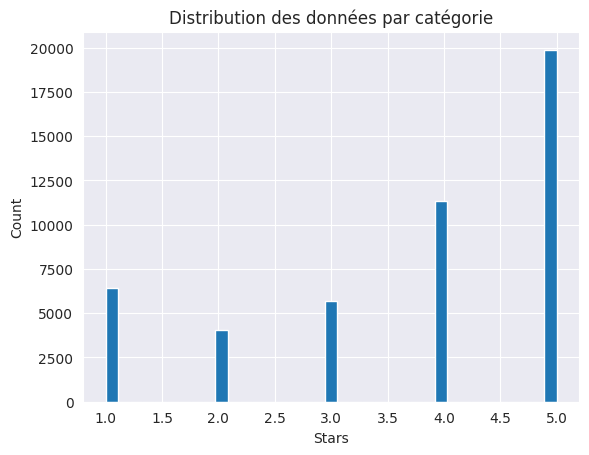


----- Pré-traitement -----

----- Découpage train/test -----

----- Vectorisation par TFIDF -----

----- Running des models sur les données traitées par TFIDF -----
Données non traitées :
################## RF #############
MAE = 0.735, Accuracy = 0.457


array([[ 587,  841,  472,  221,   23],
       [  78,  405,  514,  337,   44],
       [  34,  213,  722,  822,   96],
       [   8,  104,  612, 2217,  720],
       [   8,  104,  456, 2779, 3216]])


################## KNN #############
MAE = 0.918, Accuracy = 0.361


array([[ 271,  632,  707,  440,   94],
       [  62,  242,  507,  496,   71],
       [  28,  153,  600,  931,  175],
       [   9,  105,  756, 2049,  742],
       [  16,  133,  921, 3013, 2480]])


################## MLP #############
MAE = 0.752, Accuracy = 0.507


array([[1250,  445,  202,  141,  106],
       [ 371,  361,  302,  224,  120],
       [ 167,  339,  468,  589,  324],
       [ 114,  255,  511, 1311, 1470],
       [ 141,  234,  377, 1270, 4541]])


Données pré-traitées :
################## RF #############
MAE = 0.735, Accuracy = 0.457


array([[ 587,  841,  472,  221,   23],
       [  78,  405,  514,  337,   44],
       [  34,  213,  722,  822,   96],
       [   8,  104,  612, 2217,  720],
       [   8,  104,  456, 2779, 3216]])


################## KNN #############
MAE = 0.918, Accuracy = 0.361


array([[ 271,  632,  707,  440,   94],
       [  62,  242,  507,  496,   71],
       [  28,  153,  600,  931,  175],
       [   9,  105,  756, 2049,  742],
       [  16,  133,  921, 3013, 2480]])


################## MLP #############
MAE = 0.752, Accuracy = 0.507


array([[1250,  445,  202,  141,  106],
       [ 371,  361,  302,  224,  120],
       [ 167,  339,  468,  589,  324],
       [ 114,  255,  511, 1311, 1470],
       [ 141,  234,  377, 1270, 4541]])



----- Sélection des mots clés pertinents -----
Données pré-traitées :
['great' 'worst' 'told' 'amazing' 'best' 'rude' 'horrible' 'delicious'
 'love' 'good' 'friendly' 'terrible' 'awesome' 'excellent' 'asked'
 'highly' 'definitely' 'said' 'ok' 'food' 'bland' 'nice' 'bad' 'place'
 'poor' 'just' 'wasn' 'perfect' 'don' 'minutes']


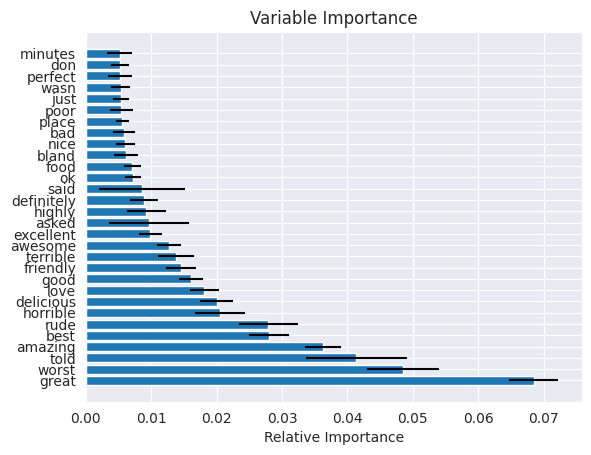


----- Vectorisation par SVD ------
Données pré-traitées :
Concept 0: food(0.23) good(0.22) great(0.21) place(0.21) service(0.17)
Concept 1: food(0.37) good(0.25) great(0.18) chicken(0.15) delicious(0.13)
Concept 2: great(0.58) service(0.19) staff(0.19) friendly(0.19) love(0.14)
Concept 3: pizza(0.45) love(0.31) place(0.31) best(0.12) like(0.1)
Concept 4: pizza(0.75) service(0.21) great(0.15) customer(0.11) crust(0.11)
Concept 5: good(0.55) pizza(0.3) really(0.12) pretty(0.12) service(0.11)
Concept 6: great(0.52) room(0.15) bar(0.11) nice(0.11) burger(0.1)
Concept 7: good(0.49) chicken(0.15) recommend(0.15) car(0.14) friendly(0.14)
Concept 8: staff(0.36) friendly(0.29) room(0.26) hotel(0.21) nice(0.18)
Concept 9: staff(0.38) friendly(0.36) love(0.19) place(0.12) order(0.12)
Concept 10: amazing(0.33) good(0.25) time(0.24) burger(0.24) recommend(0.16)
Concept 11: sushi(0.47) place(0.42) recommend(0.17) service(0.14) rolls(0.13)
Concept 12: love(0.5) service(0.39) burger(0.2) customer(0.1

array([[ 268,  904,  727,  224,   21],
       [  32,  300,  711,  318,   17],
       [   7,  145,  899,  771,   65],
       [   3,   65,  807, 2265,  521],
       [   2,   87,  677, 3091, 2706]])


################## KNN #############
MAE = 0.872, Accuracy = 0.387


array([[ 508,  755,  585,  269,   27],
       [ 115,  324,  519,  362,   58],
       [  43,  262,  739,  724,  119],
       [  22,  206,  972, 1868,  593],
       [  38,  240, 1015, 2652, 2618]])


################## MLP #############
MAE = 0.658, Accuracy = 0.520


array([[ 898,  727,  336,  157,   26],
       [ 172,  473,  448,  252,   33],
       [  36,  308,  661,  743,  139],
       [  16,  120,  618, 1848, 1059],
       [   8,  116,  394, 1801, 4244]])


Données pré-traitées :
################## RF #############
MAE = 0.795, Accuracy = 0.408


array([[ 263,  914,  732,  214,   21],
       [  38,  314,  677,  325,   24],
       [   6,  164,  892,  761,   64],
       [   5,   71,  833, 2237,  515],
       [   5,   86,  706, 3086, 2680]])


################## KNN #############
MAE = 0.872, Accuracy = 0.387


array([[ 521,  731,  602,  253,   37],
       [ 117,  322,  538,  346,   55],
       [  37,  267,  740,  724,  119],
       [  25,  186, 1008, 1835,  607],
       [  36,  251, 1019, 2629, 2628]])


################## MLP #############
MAE = 0.662, Accuracy = 0.516


array([[ 833,  816,  319,  148,   28],
       [ 139,  501,  448,  255,   35],
       [  34,  319,  654,  763,  117],
       [   8,  121,  613, 1936,  983],
       [  16,  119,  364, 1921, 4143]])



------ Préparation du model Word2Vec entrainé -----


Sauvegarde du model
Test du model
Tests de quelques mots vectorisés :

Test : mot 'girl' vectorisé
[ 0.10312091 -0.70560855  0.5499766  -1.4694374  -1.6491077  -1.0275662
 -0.2644725  -0.423115    0.45817155  0.07689855 -0.58414674  0.15973936
  0.51066303 -3.7331917   0.20100397 -0.11499757  0.21464683  0.56295884
  0.19927028 -0.25202757  0.19348559  1.2023727   0.5850089   0.84045625
  0.11774091 -1.1602439   0.2053686   1.9022698  -0.4614632   2.0802562
  1.0190312  -0.03829304  1.9691628  -1.0147941   1.8664554   0.3906925
 -0.4597123   0.42637455 -0.33134854  0.25160688 -0.42074835 -0.14685544
 -0.70804936 -2.117181    0.59250474  0.3147221   0.48280412  0.45364487
  1.0777236   0.43447864  1.5305372  -0.3775104   0.37578866 -0.4841972
 -0.61247593  0.10359848 -0.79832184  1.906345   -0.30506232  1.2109855
 -0.33888206  0.24325714  1.755366   -1.152747    2.8333108   0.58997077
  1.8661791  -0.8302658   2.4256623  -0.39403117 -0.37474433  0.14882281
 -0.8060876  -0.82724506 -0.62

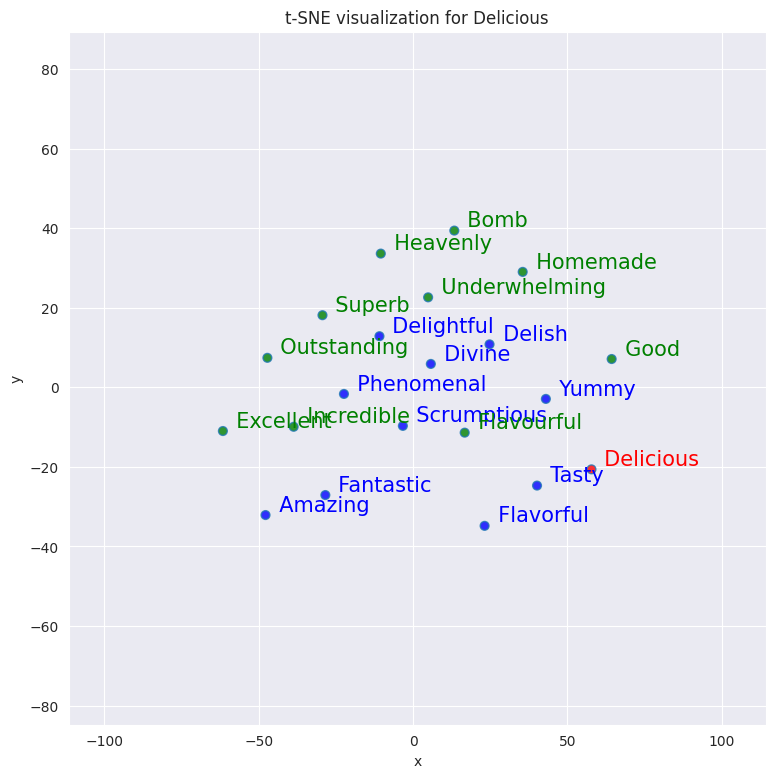


Test du mot : girl


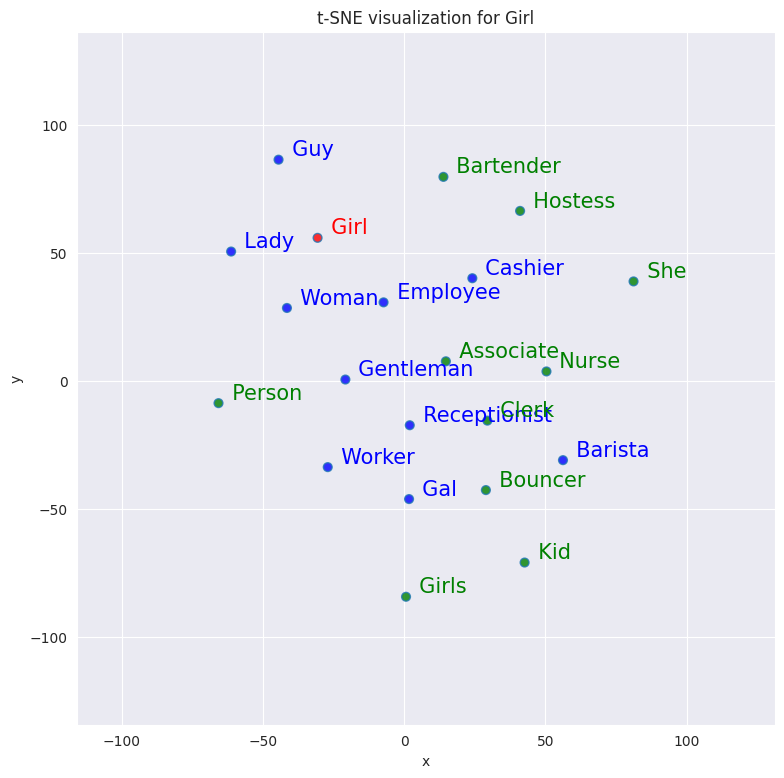


----- Running des models sur les données traitées par Word2Vec -----
################## RF #############
MAE = 0.843, Accuracy = 0.376


array([[ 155,  809,  882,  281,   17],
       [  19,  274,  741,  336,    8],
       [   3,  138,  808,  920,   18],
       [   2,   79,  734, 2438,  408],
       [   0,   85,  789, 3479, 2210]])


################## KNN #############
MAE = 0.840, Accuracy = 0.408


array([[ 429,  764,  594,  315,   42],
       [  71,  301,  516,  454,   36],
       [  40,  180,  660,  908,   99],
       [  17,  146,  749, 2120,  629],
       [  32,  191,  746, 2727, 2867]])


################## MLP #############
MAE = 0.642, Accuracy = 0.537


array([[ 860,  770,  312,  168,   34],
       [ 140,  482,  483,  229,   44],
       [  45,  307,  739,  686,  110],
       [  17,  148,  653, 1819, 1024],
       [  33,  129,  350, 1556, 4495]])



----- Vectorisation avec Word2Vec pré-entrainé de Google -----
################## RF #############
MAE = 0.811, Accuracy = 0.381


array([[ 258,  839,  826,  213,    8],
       [  35,  272,  731,  337,    3],
       [  15,  124,  817,  905,   26],
       [   2,   58,  714, 2530,  357],
       [   4,   80,  614, 3793, 2072]])


################## KNN #############
MAE = 0.832, Accuracy = 0.394


array([[ 510,  839,  578,  206,   11],
       [  85,  369,  569,  327,   28],
       [  36,  199,  713,  873,   66],
       [  19,  141,  767, 2269,  465],
       [  27,  226,  866, 3147, 2297]])


################## MLP #############
MAE = 0.612, Accuracy = 0.537


array([[ 765,  976,  293,  100,   10],
       [ 105,  607,  410,  239,   17],
       [  26,  315,  620,  845,   81],
       [  12,  114,  477, 2165,  893],
       [   9,   68,  267, 1978, 4241]])



----- Détermination du meilleur traitement -----
Meilleur traitement : Word2Vec_Google
Meilleur algo : MLP
Score MAE : 0.6122355340632014
Score Accuracy : 0.5371969551589586
preprocessing : FunctionTransformer(func=<function denoise_data at 0x7a89734a2d40>)
traitement : FunctionTransformer(func=functools.partial(<function traitement_word2vec at 0x7a8973377eb0>, corpus_test=None, model_wv_entraine_kv=<gensim.models.keyedvectors.KeyedVectors object at 0x7a896b223af0>, vector_size=300))
algo : MLPRegressor(alpha=0.001, hidden_layer_sizes=(20, 10), random_state=1)

----- Création de la pipeline -----
Sauvegarde de la pipeline
Pipeline sauvegardé

----- Prédiction par LSTM -----



In [ ]:
main_function('/content/drive/MyDrive/Colab Notebooks/Master_Info/M2/Machine_Learning/TP/Tps_Haytham_Elghazel/TP_TraitementDeTexte/yelp-text-by-stars.csv')